# THIS FILE IS IN THE HANDOUTS FOLDER. COPY IT INTO YOUR CLASS NOTES

- [**Read the chapter on the website!**](https://ledatascifi.github.io/ledatascifi-2025/content/05/02_reg.html) It contains a lot of extra information we won't cover in class extensively.
- After reading that, I recommend [this webpage as a complimentary place to get additional intuition.](https://aeturrell.github.io/coding-for-economists/econmt-regression.html)

## Today

[Finish picking teams and declare initial project interests in the project sheet](https://docs.google.com/spreadsheets/d/1SMetWKgI3JdhFdBwihDgIY3BDubvihkJCWbgLcCe4fs/edit?usp=sharing)


# Today is mostly about INTERPRETING COEFFICIENTS (6.4 in the book)

1. 25 min reading groups: Talk/read through two regression pages (6.3 and 6.4) 
    - Assemble your own notes. Perhaps in the "Module 4 notes" file, but you can do this in any file you want.
    - After class, each group will email their notes to the TA/me for participation. (Effort grading.)
1. 10 min: class builds joint "big takeaways and nuanced observations" 
1. 5 min: Interpret models 1-2 as class as practice. 
1. 20 min reading groups: Work through remaining problems below.
1. 10 min: wrap up  

---

In [2]:
import pandas as pd
from statsmodels.formula.api import ols as sm_ols
import numpy as np
import seaborn as sns
from statsmodels.iolib.summary2 import summary_col # nicer tables
import matplotlib.pyplot as plt


In [3]:
url = 'https://github.com/LeDataSciFi/ledatascifi-2025/blob/main/data/Fannie_Mae_Plus_Data.gzip?raw=true'
fannie_mae = pd.read_csv(url,compression='gzip') 

## Clean the data and create variables you want

In [4]:
fannie_mae = (fannie_mae
                  # create variables
                  .assign(l_credscore = np.log(fannie_mae['Borrower_Credit_Score_at_Origination']),
                          l_LTV = np.log(fannie_mae['Original_LTV_(OLTV)']),
                          l_int = np.log(fannie_mae['Original_Interest_Rate']),
                          Origination_Date = lambda x: pd.to_datetime(x['Origination_Date']),
                          Origination_Year = lambda x: x['Origination_Date'].dt.year,
                          const = 1
                         )
                  .rename(columns={'Original_Interest_Rate':'int'}) # shorter name will help the table formatting
             )

# create a categorical credit bin var with "pd.cut()"
fannie_mae['creditbins']= pd.cut(fannie_mae['Co-borrower_credit_score_at_origination'],
                                 [0,579,669,739,799,850],
                                 labels=['Very Poor','Fair','Good','Very Good','Exceptional'])


In [5]:
fannie_mae.describe()

,Loan_Identifier,int,Original_UPB,Original_Loan_Term,Original_LTV_(OLTV),Original_Combined_LTV_(CLTV),Number_of_Borrowers,Original_Debt_to_Income_Ratio,Borrower_Credit_Score_at_Origination,Number_of_units,...,DEXUSEU,BOPGSTB,GOLDAMGBD228NLBM,CSUSHPISA,MSPUS,l_credscore,l_LTV,l_int,Origination_Year,const
count,1.350380e+05,135038.000000,1.350380e+05,135038.000000,135038.000000,134007.000000,135007.00000,132396.000000,134481.000000,135038.000000,...,135038.000000,135038.000000,135038.000000,135038.000000,135038.000000,134481.000000,135038.000000,135038.000000,135038.000000,135038.0
mean,5.518023e+11,5.238376,1.889311e+05,307.064826,70.057295,70.860858,1.58791,33.298733,742.428797,1.035027,...,1.180771,-42336.575453,845.949803,148.634283,231137.664954,6.607209,4.207508,1.624759,2007.948592,1.0
min,1.000020e+11,2.250000,8.000000e+03,60.000000,4.000000,4.000000,1.00000,1.000000,361.000000,1.000000,...,0.852538,-67823.000000,256.197727,93.236000,157400.000000,5.888878,1.386294,0.810930,1999.000000,1.0
25%,3.270665e+11,4.250000,1.080000e+05,240.000000,60.000000,61.000000,1.00000,25.000000,707.000000,1.000000,...,1.072658,-45943.000000,350.765217,130.151000,190100.000000,6.561031,4.094345,1.446919,2003.000000,1.0
50%,5.525325e+11,5.250000,1.640000e+05,360.000000,75.000000,75.000000,2.00000,33.000000,755.000000,1.000000,...,1.191335,-41360.000000,857.726190,145.632000,224100.000000,6.626718,4.317488,1.658228,2008.000000,1.0
75%,7.773282e+11,6.125000,2.470000e+05,360.000000,80.000000,80.000000,2.00000,42.000000,786.000000,1.000000,...,1.316019,-36519.000000,1273.579545,169.868000,258400.000000,6.666957,4.382027,1.812379,2013.000000,1.0
max,9.999850e+11,11.000000,1.170000e+06,360.000000,97.000000,142.000000,8.00000,64.000000,850.000000,4.000000,...,1.575864,-15946.000000,1780.647727,202.411000,337900.000000,6.745236,4.574711,2.397895,2018.000000,1.0
std,2.597821e+11,1.289895,1.087424e+05,82.331674,17.493178,17.566607,0.50841,11.508698,53.428076,0.244345,...,0.172754,9404.518716,498.115360,24.712708,46186.084143,0.074675,0.316363,0.253049,5.497838,0.0


## Statsmodels

As before, the psuedocode:
```python
model = sm_ols(<formula>, data=<dataframe>)
result=model.fit()

# you use result to print summary, get predicted values (.predict) or residuals (.resid)
```

Now, let's save each regression's result with a different name, and below this, output them all in one nice table:

In [5]:
# one var: 'y ~ x' means fit y = a + b*X

reg1 = sm_ols('int ~  Borrower_Credit_Score_at_Origination ', data=fannie_mae).fit()

reg1b= sm_ols('int ~  l_credscore  ',  data=fannie_mae).fit()

reg1c= sm_ols('l_int ~  Borrower_Credit_Score_at_Origination  ',  data=fannie_mae).fit()

reg1d= sm_ols('l_int ~  l_credscore  ',  data=fannie_mae).fit()

# multiple variables: just add them to the formula
# 'y ~ x1 + x2' means fit y = a + b*x1 + c*x2
reg2 = sm_ols('int ~  l_credscore + l_LTV ',  data=fannie_mae).fit()

# interaction terms: Just use *
# Note: always include each variable separately too! (not just x1*x2, but x1+x2+x1*x2)
reg3 = sm_ols('int ~  l_credscore + l_LTV + l_credscore*l_LTV',  data=fannie_mae).fit()
      
# categorical dummies: C() 
reg4 = sm_ols('int ~  C(creditbins)  ',  data=fannie_mae).fit()

reg5 = sm_ols('int ~  C(creditbins)  -1', data=fannie_mae).fit()


Ok, time to output them:

In [6]:
# now I'll format an output table
# I'd like to include extra info in the table (not just coefficients)
info_dict={'R-squared' : lambda x: f"{x.rsquared:.2f}",
           'Adj R-squared' : lambda x: f"{x.rsquared_adj:.2f}",
           'No. observations' : lambda x: f"{int(x.nobs):d}"}

# q4b1 and q4b2 name the dummies differently in the table, so this is a silly fix
reg4.model.exog_names[1:] = reg5.model.exog_names[1:]  

# This summary col function combines a bunch of regressions into one nice table
print('='*108)
print('                  y = interest rate if not specified, log(interest rate else)')
print(summary_col(results=[reg1,reg1b,reg1c,reg1d,reg2,reg3,reg4,reg5], # list the result obj here
                  float_format='%0.2f',
                  stars = True, # stars are easy way to see if anything is statistically significant
                  model_names=['1','2',' 3 (log)','4 (log)','5','6','7','8'], # these are bad names, lol. Usually, just use the y variable name
                  info_dict=info_dict,
                  regressor_order=[ 'Intercept','Borrower_Credit_Score_at_Origination','l_credscore','l_LTV','l_credscore:l_LTV',
                                  'C(creditbins)[Very Poor]','C(creditbins)[Fair]','C(creditbins)[Good]','C(creditbins)[Vrey Good]','C(creditbins)[Exceptional]']
                  )
     )

                  y = interest rate if not specified, log(interest rate else)

                                        1        2      3 (log) 4 (log)     5         6        7        8   
------------------------------------------------------------------------------------------------------------
Intercept                            11.58*** 45.37*** 2.87***  9.50***  44.13*** -16.81*** 6.65***         
                                     (0.05)   (0.29)   (0.01)   (0.06)   (0.30)   (4.11)    (0.08)          
Borrower_Credit_Score_at_Origination -0.01***          -0.00***                                             
                                     (0.00)            (0.00)                                               
l_credscore                                   -6.07***          -1.19*** -5.99*** 3.22***                   
                                              (0.04)            (0.01)   (0.04)   (0.62)                    
l_LTV                                            

# Today. Work in groups. Refer to the lectures. 

You might need to print out a few individual regressions with more decimals.

1. Interpret coefs in model 1-4
1. Interpret coefs in model 5
1. Interpret coefs in model 6 (and visually?)
1. Interpret coefs in model 7 (and visually? + comp to table)
1. Interpret coefs in model 8 (and visually? + comp to table)
1. Add l_LTV  to Model 8 and interpret (and visually?)





In [7]:
# reg1.summary() # to see the coef in full: -0.0086

## Model 1: int = 11.58 - 0.0086 credit

- beta_0: If the credit score is 0, the expected interest rate is 11.58
- If X↑  1 unit, then y↑  by βunits
- beta_1: A 1 unit increase in credit score is associated with a 0.01 p.p. decrease in the interest rate"
- If cred = 700, int = 5.56
- If cred = 707, int = 5.50
- Going from 700 to 707: rate falls 6 basis points


In [ ]:
print(11.58 - 0.0086*0)
print(11.58 - 0.0086*700)
print(11.58 - 0.0086*707)

5.5600000000000005

<Axes: xlabel='Borrower_Credit_Score_at_Origination'>

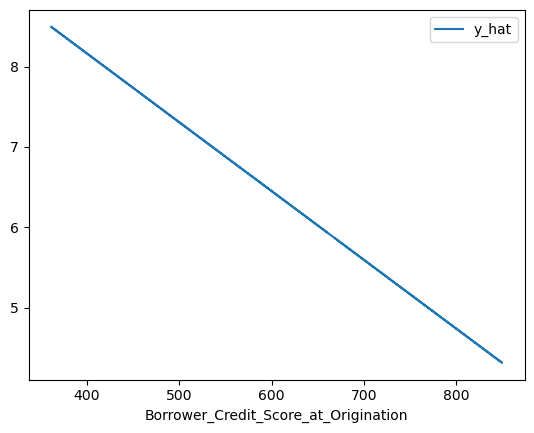

In [ ]:
(
    fannie_mae
    .dropna(subset=['Borrower_Credit_Score_at_Origination']) # drop missing values so the next line works
    .assign(y_hat = lambda x: reg1.predict(x))
    .plot(x='Borrower_Credit_Score_at_Origination',y='y_hat',kind='line')
)

# below... I'll plot models 1-4 all at once 


## Model 2: int = 45.37 - 6.07 log(credit)

- beta_0: If log(credit) is 0, (same as credit = 1), the expected interest rate is 45.37
- The table in 6.4 says: If X↑ 1%, then y↑  by about β/100 units
- beta_1: A 1 % increase in credit score is associated with a 0.0607 p.p. decrease in the interest rate"
- If cred = 700, int = 5.605
- If cred = 707, int = 5.545
- Going from 700 to 707: rate falls 6 basis points


In [ ]:
print(  45.37 - 6.07* np.log(1)) 
print(  45.37 - 6.07* np.log(700)) 
print(  45.37 - 6.07* np.log(707)) 

5.604942366286529

## Model 3: log(int) = 2.8 - 0.0017 credit

- beta_0: If cred is 0, the expected interest rate is 17
- The table in 6.4 says: If X↑ 1 unit, then y↑ by about 100∗β %.
- beta_1: A 1 unit  increase in credit score is associated with a 0.17 % decrease in the interest rate"
- If cred = 700, int = 5.365
- If cred = 707, int = 5.30
- Going from 700 to 707: rate falls 6 basis points



In [ ]:
print(np.exp(2.87 - 0.0017*0))
print(np.exp(2.87 - 0.0017*700))
print(np.exp(2.87 - 0.0017*707))

17.63701819983732
5.365555971121975
5.302084260759588


In [38]:
# reg1c.summary() # to see the coef in full: -0.0017

## Model 4: log(int) = 9.5 - 1.19 log(credit)

- beta_0: If log(cred) is 0, (cred is 1) the expected interest rate is exp(9.5) === 13,359%
- The table in 6.4 says: If X↑ 1 %, then y↑ by about β %.
- beta_1: A 1 %  increase in credit score is associated with a 1.19 % decrease in the interest rate"
- If cred = 700, int = 5.49
- If cred = 707, int = 5.43
- Going from 700 to 707: rate falls 6 basis points


In [ ]:
print(np.exp(9.5 - 1.19*0))
print(np.exp(9.5 - 1.19*np.log(700)))
print(np.exp(9.5 - 1.19*np.log(707)))

13359.726829661873
5.497065482961815
5.432359161191803


## Model 5: int = 44.13 - 5.99 log(Cred) - 0.15 log(LTV)

(Start Thursday here)

- Just focusing now on beta_1...
- A one percent increase in credit score is associated with a 0.0599 p.p. (5.99 b.p.) decline in int rate, **holding all logLTV constant**
- If cred = 700, int = 5.396
- If cred = 707, int = 5.33
- Going from 700 to 707: rate falls 6 basis points


In [57]:
fannie_mae[['Original_LTV_(OLTV)']].mean()


Original_LTV_(OLTV)    70.057295
dtype: float64

In [84]:
print(44 - 5.99*np.log(700) + .15*np.log(70))
print(44 - 5.99*np.log(707) + .15*np.log(70))


5.396303079397407
5.336700597586928


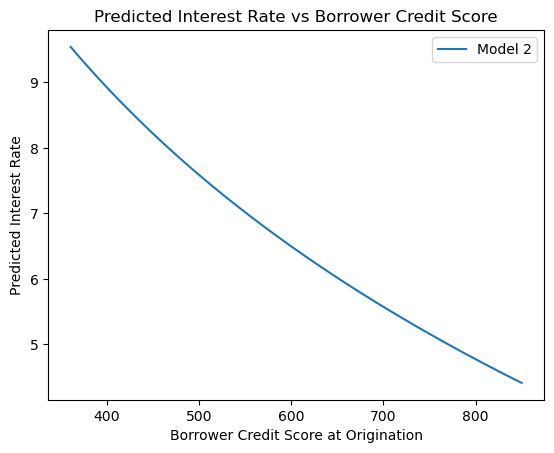

In [91]:
reg2.summary()


# plot the model using params. set LTV to its avg, 70
# y = 44 - 5.99*log(X) + .15*70
# for X from credit score min to credit score max

credit_scores = np.linspace(fannie_mae['Borrower_Credit_Score_at_Origination'].min(), 
                            fannie_mae['Borrower_Credit_Score_at_Origination'].max(), 100)
reg2_predicted_interest_rates = reg2.params.iloc[0] +\
                                reg2.params.iloc[1] * np.log(credit_scores) +\
                                reg2.params.iloc[2] * np.log(70)

plt.plot(credit_scores, reg2_predicted_interest_rates, label='Model 2')
plt.xlabel('Borrower Credit Score at Origination')
plt.ylabel('Predicted Interest Rate')
plt.title('Predicted Interest Rate vs Borrower Credit Score')
plt.legend()
plt.show()



## Model 6

The "impact" of credit score on interest now depends on logLTV. 

(We worked on the board)

In [9]:
print(-16 + 3.2*np.log(700) + 14.6*np.log(70) -2.2*np.log(700)*np.log(70) )
print(-16 + 3.2*np.log(707) + 14.6*np.log(70) -2.2*np.log(707)*np.log(70) )

5.760573611886471
5.699412017386301


## Model 7

## Model 8

## Plot models 1-4:

In [8]:
reg1.predict(fannie_mae['Borrower_Credit_Score_at_Origination'])

0         5.860809
1         5.655570
2         5.245091
3         4.706338
4         5.954878
            ...   
135033    5.450331
135034    5.792396
135035    4.843164
135036    6.271288
135037    5.937774
Length: 135038, dtype: float64

In [ ]:
# models 1-4 I just plot by adding y_hat_* to the dataframe

subset = fannie_mae.dropna(subset=['Borrower_Credit_Score_at_Origination','l_credscore']).copy()

subset['y_hat_1'] = reg1.predict(fannie_mae['Borrower_Credit_Score_at_Origination'])
subset['y_hat_2'] = reg1b.predict(fannie_mae['l_credscore'])
subset['y_hat_3'] = np.exp(reg1c.predict(fannie_mae['Borrower_Credit_Score_at_Origination']))
subset['y_hat_4'] = np.exp(reg1d.predict(fannie_mae['l_credscore']))

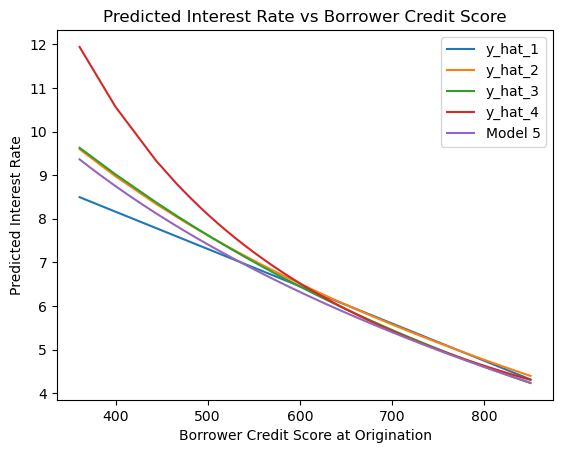

In [ ]:
# now plot
(
subset[['y_hat_1','y_hat_2','y_hat_3','y_hat_4','Borrower_Credit_Score_at_Origination']]
.sort_values('Borrower_Credit_Score_at_Origination')
.set_index('Borrower_Credit_Score_at_Origination')
.plot()
)

# to do plots for other models, just make an X array for the plot with values we want
# and then use the model to predict the y values via formula
# this is ad hoc, but built in SM plotting options don't work well for multiple models on one plot
# where some Xs are transformed for the plot 

credit_scores = np.linspace(fannie_mae['Borrower_Credit_Score_at_Origination'].min(), 
                            fannie_mae['Borrower_Credit_Score_at_Origination'].max(), 100)
reg2_predicted_interest_rates = reg2.params.iloc[0] +\
                                reg2.params.iloc[1] * np.log(credit_scores) +\
                                reg2.params.iloc[2] * np.log(70)

# add reg2 plot to this using reg2_credit_scores, reg2_predicted_interest_rates
plt.plot(reg2_credit_scores, reg2_predicted_interest_rates, label='Model 5')

plt.xlabel('Borrower Credit Score at Origination')
plt.ylabel('Predicted Interest Rate')
plt.title('Predicted Interest Rate vs Borrower Credit Score')
plt.legend()
plt.show()


Vocab:

For a given X_1 coefficient in a regression

- "null hypothesis": beta of X_1 = 0. "it is NOT related to y"
- we can reject the null
- we can NOT accept the null 
- std errors
- t-stats
- p-values
- economic significance